In [36]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [37]:
%cd /home/pengyu.zhang/project/superres/ProbSR/Experiment1

/home/pengyu.zhang/project/superres/ProbSR/Experiment1


In [38]:
from data_generation import *
from scipy.linalg import sqrtm
from downscaling import *
from utils import *
import random
import torch.nn.functional as F

In [39]:
%cd Bicubic_Downsampling

/home/pengyu.zhang/project/superres/ProbSR/Experiment1/Bicubic_Downsampling


### Model 3: Training $u_l = Hu_h + G(Hu_h)$

In [40]:
# Code downscaling matrix
N_low = 40
N_high = 160
scale = 4

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epoch_num = 500
batch_size = 8
lr = 0.01
gamma = 0.5

minimum_loss = float('inf')
loss_track = []

# Load training data
trainset = DataFromH5File5("/home/pengyu.zhang/project/superres/ProbSR/Experiment1/data/DownBy4_40_160_small8.h5",N_low,N_high,scale)
train_loader = data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)

# Initialise training model
G = ResidualLearning()
G.apply(weights_init_xavier).to(device)
mse = nn.MSELoss(reduction='sum')
optG = torch.optim.Adam(G.parameters(), lr = lr, weight_decay=0, betas=(0.5, 0.999))
r_scheduleG = torch.optim.lr_scheduler.StepLR(optG, step_size=200, gamma=gamma)

# Logger info
dir_name = f'models/pre_train/model3_8samples/40_160/lr{lr}_gamma{gamma}'
makedir(dir_name)
logger = setup_logging('job0', dir_name, console=True)
logger.info(f'Training for {epoch_num} epoches and learning rate is {lr}')

for epoch in range(1, epoch_num+1):
    
    for i, d in enumerate(train_loader, 0):
        
        residual, high_res, low_res = d
        size = residual.shape[0]
        low_res = low_res.to(device).reshape(size,1,N_low,N_low)
        high_res = high_res.to(device).reshape(size,1,N_high,N_high)
        
        downscaled = F.interpolate(high_res.reshape(size,1,N_high,N_high),(N_low,N_low))
        
        optG.zero_grad()
        out = downscaled + G(downscaled)
        loss = mse(low_res,out)/batch_size
        loss.backward()
        optG.step()
        
        if loss < minimum_loss:
            save_model(dir_name, epoch, 'best_model', r_scheduleG, G, optG)
            minimum_loss = loss
            
        if epoch%100 == 0:
            save_model(dir_name, epoch, 'model_epoch_{}'.format(epoch), r_scheduleG, G, optG)
            
        loss_track.append(loss.cpu().data.numpy())
        np.save(f'{dir_name}/chains/loss_curve.npy', np.array(loss_track))
        
        print("Epoch:", epoch, "Loss:", loss)

    r_scheduleG.step()

2024-08-06 11:24:25,833 : Training for 500 epoches and learning rate is 0.01


Epoch: 1 Loss: tensor(42.0268, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(1894.7554, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 3 Loss: tensor(2083.8574, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 4 Loss: tensor(249.1881, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 5 Loss: tensor(4.7809, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 6 Loss: tensor(51.7938, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 7 Loss: tensor(25.5430, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 8 Loss: tensor(7.1337, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 9 Loss: tensor(1.7707, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 10 Loss: tensor(1.7093, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 11 Loss: tensor(2.0498, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 12 Loss: tensor(1.4226, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 13 Loss: tensor(1.0533, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 14 Loss: tensor(1.0107, device='cuda:0', grad_fn=<DivBa

In [42]:
N_low = 40
N_high = 160
scale = 4
a, b, c = 8,3,5

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)

In [43]:
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,a,b,c)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,a,b,c)

In [44]:
G = ResidualLearning().to(device)
G.load_state_dict(torch.load('/home/pengyu.zhang/project/superres/ProbSR/Experiment1/Bicubic_Downsampling/models/pre_train/model3_8samples/40_160/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])

<All keys matched successfully>

In [45]:
w_high_tensor = torch.tensor(w_high).to(torch.float32).to(device)
w_low_tensor = torch.tensor(w_low).to(torch.float32).to(device)
downscaled = F.interpolate(w_high_tensor.reshape(1,1,N_high,N_high),(N_low,N_low)).reshape(N_low,N_low)
out = G(downscaled.reshape(1,1,N_low,N_low))
residual = w_low_tensor-downscaled

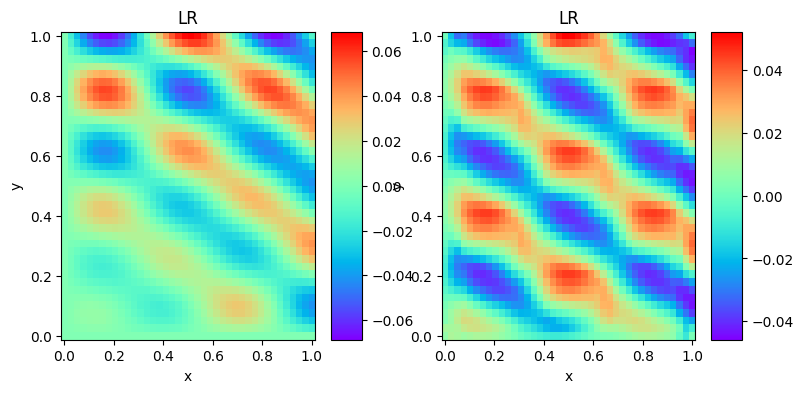

In [46]:
fig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.pcolormesh(x_low, y_low, residual.cpu().data.numpy(), cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.03, 0.03)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.pcolormesh(x_low, y_low, out.cpu().data.numpy()[0][0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.03, 0.03)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Upscale by 4

In [47]:
N_low = 40
N_high = 160
scale = 4
a,b,c = 4,5,5

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)

In [48]:
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,a,b,c)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,a,b,c)

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for prior variance
prior_sigma = 0.002
ll_sigma = 0.001

In [50]:
A_high = csr_matrix(A_high)

In [51]:
operator = (A_high.T) * (1/prior_sigma**2)
b_high = create_forcing_term(N_high,a,b,c)

In [56]:
G = ResidualLearning().to(device)
# G.load_state_dict(torch.load('models/train_NN/model3/31_121/lr0.01_gamma0.1/ckpt/best_model.pth')['netG'])
G.load_state_dict(torch.load('/home/pengyu.zhang/project/superres/ProbSR/Experiment1/Bicubic_Downsampling/models/pre_train/model3_8samples/40_160/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])

<All keys matched successfully>

In [57]:
# Parameters for Langevin dynamics
s = 0.0004
K = 50

chains_evolution = []
x = torch.tensor(w_low).to(device).to(torch.float32)
z = F.interpolate(x.reshape(1,1,N_low,N_low),(N_high,N_high),mode="bicubic").reshape(N_high,N_high)
z = z.clone().detach().requires_grad_(True)


for i in range(K):
    # Grad log-likelihood
    downscaled = F.interpolate(z.reshape(1,1,N_high,N_high),(N_low,N_low)).reshape(N_low,N_low)
    x_hat = downscaled + G(downscaled.reshape(1,N_low,N_low)).reshape(N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]
    # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    # Grad prior
    difference = A_high.dot(z.cpu().data.numpy().reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
    # log_prior = - 0.5 * difference.T @ G_inverse @ difference
    # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
    grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high)
    grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32).to(device)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high]).to(device)
    # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W
    if i > K-10:
        chains_evolution.append(z.cpu().data.numpy())  

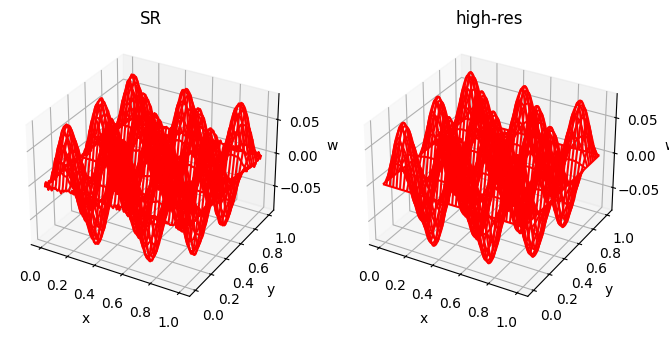

In [58]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy(),color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('SR')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high,color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

In [59]:
error1 = abs(w_high - np.mean(chains_evolution,axis=0))
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)

SR L2 Error: 2.4542456690568646e-05


In [60]:
A_high = torch.tensor(create_A(N_high)).to(torch.float32).to(device)

In [61]:
A_high = A_high.to_sparse()
operator = (A_high.T) * (1/prior_sigma**2)

In [66]:
# Parameters for prior variance
prior_sigma = 0.002
ll_sigma = 0.001

In [67]:
dataset = DataFromH5File4("/home/pengyu.zhang/project/superres/ProbSR/Experiment1/data/40_160_low_forcing.h5")

trainset = random.sample(range(0, 128), 100)
testset = [i for i in range(0,128) if i not in trainset]

In [68]:
def sample_data():
    coefficient = random.sample(trainset,1)[0]
    forcing = dataset[coefficient][0]
    lr = dataset[coefficient][1]
    
    return forcing, lr


def sample_p_0(x):
    # Randomly sampling for initialisation of the Langevin dynamics
    # prior = torch.randn(*[batch_size,1,20,20]).to(device)
    
    # Set the u_low_mean to the initialisation of the Langevin dynamics
    # posterior_initial = torch.randn([N_high,N_high]).to(torch.float32)
    # posterior_initial = torch.tensor(posterior_initial).to(device).to(torch.float32)
    posterior_initial  = F.interpolate(x.reshape(1,1,N_low,N_low),(N_high,N_high),mode="bicubic").reshape(N_high,N_high)
    
    return posterior_initial

    
def ula_posterior_preconditioner(z, b_high, x, G):
    """
    Langevin dynamics with preconditioner
    """
    z = z.clone().detach().requires_grad_(True)
    sum = 0
    for i in range(K):
        # Grad log-likelihood
        downscaled = F.interpolate(z.reshape(1,1,N_high,N_high),(N_low,N_low)).reshape(N_low,N_low)
        x_hat = downscaled + G(downscaled.reshape(1,N_low,N_low)).reshape(N_low,N_low)
        log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
        grad_ll = torch.autograd.grad(log_likelihood, z)[0]

        # Grad prior
        difference = torch.spmm(A_high,z.reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
        # log_prior = - 0.5 * difference.T @ G_inverse @ difference
        # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
        grad_log_prior = (- torch.spmm(operator,difference)).reshape(N_high,N_high)
        
        # Random noise term
        W = torch.randn(*[N_high,N_high]).to(device)
        # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
        
        z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W
        if i >= K - 10:
            sum += z

    sum /= 10
           
    return sum.detach()

In [70]:
# Train with sampled data
epoch_num = 2000
lr = 0.0005
gamma = 0.5

K = 50
s = 0.0004
step_size = 30
minimum_loss = float('inf')
loss_track = []

G = ResidualLearning().to(device)
G.load_state_dict(torch.load('/home/pengyu.zhang/project/superres/ProbSR/Experiment1/Bicubic_Downsampling/models/pre_train/model3_8samples/40_160/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])
mse = nn.MSELoss(reduction='sum')
optG = torch.optim.Adam(G.parameters(), lr = lr, weight_decay=0, betas=(0.5, 0.999))
r_scheduleG = torch.optim.lr_scheduler.StepLR(optG, step_size=step_size, gamma=gamma)

# Logger info
dir_name = f'models/after_pre_train/model3_8samples/40_160/lr{lr}_gamma{gamma}_stepsize{step_size}_K{K}_llsigma_{ll_sigma}_psigma_{prior_sigma}'
makedir(dir_name)
logger = setup_logging('job0', dir_name, console=True)
logger.info(f'Training for {epoch_num} epoches and learning rate is {lr}')

for epoch in range(1, epoch_num+1):
    
    b_high, low_res = sample_data()
    b_high = torch.tensor(b_high).to(torch.float32).to(device)
    low_res = torch.tensor(low_res).to(torch.float32).to(device)
    
    posterior_initial = sample_p_0(low_res)
    posterior_final = ula_posterior_preconditioner(posterior_initial, b_high, low_res, G)

    optG.zero_grad()
    
    downscaled = F.interpolate(posterior_final.reshape(1,1,N_high,N_high),(N_low,N_low)).reshape(1,N_low,N_low)
    out = G(downscaled.reshape(1,N_low,N_low)) + downscaled
    loss = mse(out,low_res.reshape(1,N_low,N_low))
        
    loss.backward()
    optG.step()
    
    if loss < minimum_loss:
        save_model(dir_name, epoch, 'best_model', r_scheduleG, G, optG)
        minimum_loss = loss
            
    if epoch%100 == 0:
        save_model(dir_name, epoch, 'model_epoch_{}'.format(epoch), r_scheduleG, G, optG)
    
    save_model(dir_name, epoch, 'current_epoch', r_scheduleG, G, optG)
    loss_track.append(loss.cpu().data.numpy())
    np.save(f'{dir_name}/chains/loss_curve.npy', np.array(loss_track))
    
    print("Epoch:", epoch, "Loss:", loss)

    r_scheduleG.step()

2024-08-06 11:33:45,517 : Training for 2000 epoches and learning rate is 0.0005


Epoch: 1 Loss: tensor(0.0287, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 2 Loss: tensor(0.4408, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 3 Loss: tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 4 Loss: tensor(0.1376, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 5 Loss: tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 6 Loss: tensor(0.0569, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 7 Loss: tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 8 Loss: tensor(3.9881, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 9 Loss: tensor(0.1755, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 10 Loss: tensor(4.3884, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 11 Loss: tensor(0.1831, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 12 Loss: tensor(0.0944, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 13 Loss: tensor(0.0363, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 14 Loss: tenso